In [1]:
from sklearn.datasets import load_wine
import numpy as np
import warnings

warnings.filterwarnings('ignore')

wine = load_wine()

In [2]:
wine.data.shape

(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

seed = 2033
train, test, labels_train, labels_test = train_test_split(wine.data, wine.target,
                                                          train_size=0.70, test_size=0.30,
                                                          random_state=seed)
categorical_features = np.argwhere(
    np.array([len(set(wine.data[:, x])) for x in range(wine.data.shape[1])]) <= 10).flatten()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Activation, Dense, Dropout
from keras.utils import to_categorical

model = RandomForestClassifier(random_state=seed)
# model = AdaBoostClassifier(random_state=2022)
# model = GradientBoostingClassifier(random_state=2022)
# labels_train2 = to_categorical(labels_train, 2)
# labels_test2 = to_categorical(labels_test, 2)
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=30))
# model.add(Dropout(0.2))
# model.add(Dense(2, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# model.fit(train, labels_train2, batch_size=32, epochs=50, validation_data=(test, labels_test2))
model.fit(train, labels_train)

Using TensorFlow backend.


RandomForestClassifier(random_state=2033)

In [5]:
pred_origin = model.predict_proba(test)
pred_origin = np.argmax(pred_origin, axis=1)

In [6]:
from sklearn.preprocessing import MinMaxScaler

feature_importances = MinMaxScaler().fit_transform(model.feature_importances_.reshape(-1, 1))
feature_importances = feature_importances.flatten()
feature_importances


array([0.5083839 , 0.0929254 , 0.03341446, 0.13822594, 0.02144902,
       0.2191055 , 1.        , 0.        , 0.11719137, 0.73076141,
       0.35663745, 0.48858359, 0.69801474])

In [7]:
import sys

sys.path.append('..')
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=wine.feature_names,
                                                   categorical_features=categorical_features, verbose=False,
                                                   mode='classification', random_state=seed
                                                   # , discretize_continuous=False
                                                   )

[('color_intensity <= 3.30', 3.075457269713316), ('flavanoids <= 1.07', -2.118298917666576), ('alcohol <= 12.42', 1.5946217137784584), ('510.00 < proline <= 676.50', 0.6803909155588167), ('malic_acid <= 1.61', 0.5594469124250258), ('alcalinity_of_ash <= 17.08', 0.5087009665379036), ('0.94 < hue <= 1.12', 0.5066509003040711), ('ash <= 2.20', 0.49940194061826126), ('od280/od315_of_diluted_wines <= 1.82', -0.4132913579111713), ('1.67 < total_phenols <= 2.20', 0.21397777980735008), ('magnesium <= 89.00', 0.15258824406417437), ('proanthocyanins <= 1.14', 0.12422861246888661), ('0.27 < nonflavanoid_phenols <= 0.34', -0.10895031330691177)]
[-0.10895031330691177, 0.12422861246888661, 0.15258824406417437, 0.21397777980735008, -0.4132913579111713, 0.49940194061826126, 0.5066509003040711, 0.5087009665379036, 0.5594469124250258, 0.6803909155588167, 1.5946217137784584, -2.118298917666576, 3.075457269713316]
['0.27 < nonflavanoid_phenols <= 0.34', 'proanthocyanins <= 1.14', 'magnesium <= 89.00', '1.

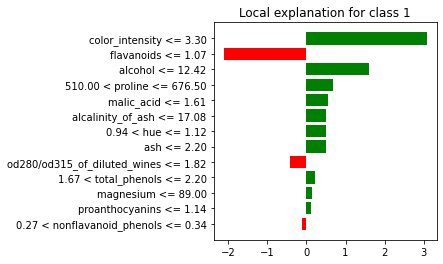

In [8]:
exp = explainer.explain_instance(test[25], model.predict_proba, num_features=13
                                 , labels=(0, 1, 2)
                                 # , model_regressor='DecisionTreeClassifier'
                                 )
exp.as_pyplot_figure(label=1)
print(exp.local_pred[1])

In [9]:
import tqdm as td
from sklearn.metrics.pairwise import cosine_similarity

pred_lime = []
cos_sim_list = []
for k in td.tqdm(test):
    exp = explainer.explain_instance(k, model.predict_proba, num_features=13, labels=(0, 1, 2)
                                     ,model_regressor='ensemble'
                                     , num_samples=5000
                                     # , model_regressor='DecisionTreeClassifier'
                                     )
    # print(exp.local_pred)
    pred_lime.append([exp.local_pred[0], exp.local_pred[1], exp.local_pred[2]])
    coef_list = np.zeros(13)
    # print(len(exp.local_exp))
    for i in exp.local_exp:
        # print(exp.local_exp[i])
        for j in exp.local_exp[i]:
            if isinstance(j[1], np.ndarray):
                coef_list[j[0]] += j[1].tolist()[0]
            else:
                coef_list[j[0]] += j[1]
    coef_list = coef_list / len(exp.local_exp)
    coef_list = MinMaxScaler().fit_transform(coef_list.reshape(-1, 1)).flatten()
    # print(coef_list)
    importance_coef = []
    importance_coef.append(feature_importances.tolist())
    importance_coef.append(coef_list.tolist())
    # print(importance_coef)
    # print('cos_sim:', cosine_similarity(importance_coef)[0][1])
    cos_sim_list.append(cosine_similarity(importance_coef)[0][1])
print(np.sum(cos_sim_list) / len(cos_sim_list))

100%|██████████| 54/54 [00:48<00:00,  1.12it/s]

0.8286529380999973


In [10]:
pred_lime = np.argmax(pred_lime, axis=1)
# pred_lime

In [11]:
from sklearn.metrics import classification_report

print('\nClassification Report:\n', classification_report(labels_test, pred_origin, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        19
           1     1.0000    1.0000    1.0000        23
           2     1.0000    1.0000    1.0000        12

    accuracy                         1.0000        54
   macro avg     1.0000    1.0000    1.0000        54
weighted avg     1.0000    1.0000    1.0000        54



In [12]:
print('\nClassification Report:\n', classification_report(labels_test, pred_lime, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9474    0.9730        19
           1     0.9200    1.0000    0.9583        23
           2     1.0000    0.9167    0.9565        12

    accuracy                         0.9630        54
   macro avg     0.9733    0.9547    0.9626        54
weighted avg     0.9659    0.9630    0.9631        54



In [13]:
print('\nClassification Report:\n', classification_report(pred_origin, pred_lime, digits=4))


Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9474    0.9730        19
           1     0.9200    1.0000    0.9583        23
           2     1.0000    0.9167    0.9565        12

    accuracy                         0.9630        54
   macro avg     0.9733    0.9547    0.9626        54
weighted avg     0.9659    0.9630    0.9631        54

